In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
# Load the dataset
data = pd.read_csv('/Users/macbookair/Desktop/ML4QS_Group125/data_w_features_ver2/data_w_all_features_final.csv')
# Create the target column
data['target'] = data.apply(
    lambda row: f"{'native' if row['language'] in ['ch', 'ru', 'tr'] else 'non-native'} {row['tone']}", axis=1)

# Encode the target labels
label_encoder = LabelEncoder()
data['target_encoded'] = label_encoder.fit_transform(data['target'])
# Print the mapping of labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


# Split the data into training and testing sets based on participant
train_data = data[data['participant'] != "subject3"]
test_data = data[data['participant'] == "subject3"]

train_data = train_data.drop(columns=['participant', 'script', 'target', 'language', 'tone'])
test_data = test_data.drop(columns=['participant', 'script', 'target', 'language', 'tone'])

# Drop unnecessary columns
X_train = train_data.drop(columns=['target_encoded'])
y_train = train_data['target_encoded']
X_test = test_data.drop(columns=['target_encoded'])
y_test = test_data['target_encoded']


print("Train and test sets created.")

Label mapping: {'native bus': 0, 'native casual': 1, 'non-native bus': 2, 'non-native casual': 3}
Train and test sets created.


In [3]:
print("Target distribution in training data:")
print(train_data['target_encoded'].value_counts())

print("Target distribution in test data:")
print(test_data['target_encoded'].value_counts())


Target distribution in training data:
2    3976
3    3112
0    2806
1    2375
Name: target_encoded, dtype: int64
Target distribution in test data:
2    535
3    381
0    277
1    227
Name: target_encoded, dtype: int64


In [4]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed.")

Data preprocessing completed.


                                               feature  importance
165               amplitude_mean_kalman_temp_max_ws_10    0.089882
173                pitch_mean_kalman_temp_median_ws_10    0.034535
81   temp_pattern_amplitude_mean_kalman_categorical...    0.029693
166         sound_intensity_mean_kalman_temp_max_ws_10    0.025052
0                                             time_0.5    0.020412
..                                                 ...         ...
143  temp_pattern_sound_intensity_mean_kalman_categ...    0.000000
65                  pitch_mean_kalman_categorical_high    0.000000
109  temp_pattern_pitch_mean_kalman_categorical_low...    0.000000
63               amplitude_mean_kalman_categorical_low    0.000000
69         sound_intensity_mean_kalman_categorical_low    0.000000

[180 rows x 2 columns]


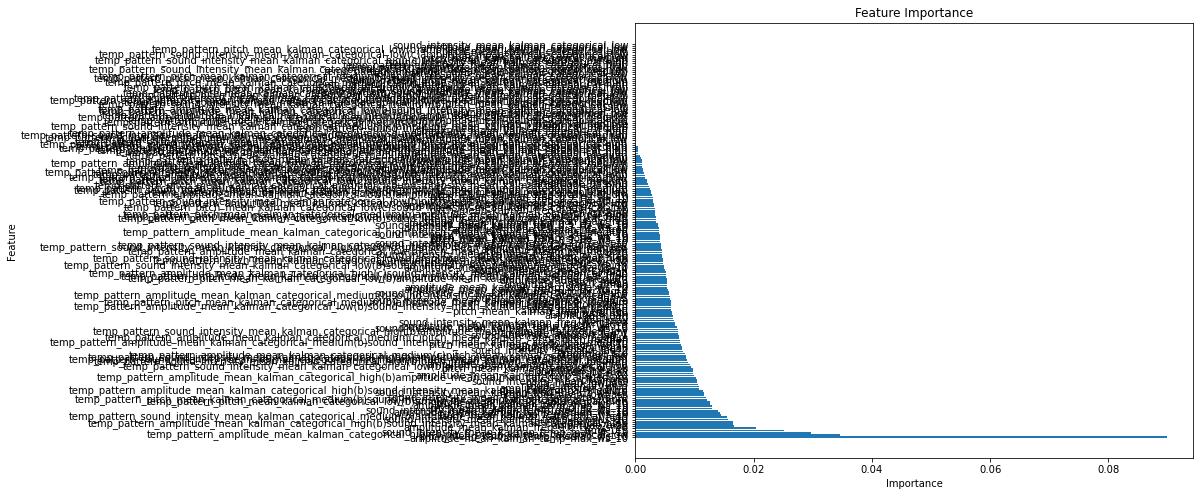

In [6]:
# Initialize the model
model = XGBClassifier(random_state=42)

model.fit(X_train_scaled, y_train)
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature importance
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()




In [7]:
# Select top N features
top_n = 10
top_features = feature_importance_df['feature'].head(top_n).tolist()

# Alternatively, use a cumulative importance threshold
cumulative_importance = 0.95
cumulative_importance_threshold = feature_importance_df['importance'].cumsum() >= cumulative_importance
top_features = feature_importance_df[cumulative_importance_threshold]['feature'].tolist()


In [8]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Scale the new datasets
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)


In [9]:
# Initialize the model
model = XGBClassifier(random_state=42)

# Train the model with selected features
model.fit(X_train_selected_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
# Make predictions
y_pred = model.predict(X_test_selected_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.27      0.25       277
           1       0.09      0.10      0.10       227
           2       0.34      0.22      0.27       535
           3       0.21      0.27      0.24       381

    accuracy                           0.23      1420
   macro avg       0.22      0.22      0.21      1420
weighted avg       0.24      0.23      0.23      1420



In [10]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
}
# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

In [11]:
# Get best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)
# Train model with best parameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)


Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 350}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:

# Make predictions
y_pred_best = best_model.predict(X_test_scaled)

# Evaluate the optimized model
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.31      0.50      0.38       277
           1       0.27      0.11      0.15       227
           2       0.41      0.23      0.30       535
           3       0.18      0.27      0.22       381

    accuracy                           0.28      1420
   macro avg       0.29      0.28      0.26      1420
weighted avg       0.31      0.28      0.27      1420

